In [ ]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import random
import time, pickle
from scipy import signal

In [ ]:
# Initial
AF_0 = []
AF_d = []

lamda = 1  # wavelength
d = lamda / 2  # wavelength is 1m
k = 2 * np.pi / lamda

theta = np.arange(-90, 91, 1)
thetai = np.array([14])
lb = -0.1
ub = 0.1
Npop = 50  # number of bat
Max_iteration = 10  # Iteration
MAX_MC = 1 # Montecarlord iteration
# b = 1
c = 10000  # Penalty parameter
A = 0.5  # Loudness  (constant or decreasing)
r = 0.5  # Pulse rate (constant or decreasing)
Qmin = 0  # Frequency minimum
Qmax = 1  # Frequency maximum
numAnt = 20
I = np.isin(theta,thetai)
theta_k = theta[~I]
start_time = time.time()

dim = int(numAnt/2)
wd = signal.chebwin(numAnt, at=30)

<ipython-input-11-aeb8599ed02a>:28: DeprecationWarning: Importing chebwin from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.chebwin' or the convenience function 'scipy.signal.get_window' instead.
  wd = signal.chebwin(numAnt, at=30)
/usr/local/lib/python3.10/dist-packages/scipy/signal/windows/_windows.py:1543: UserWarning: This window is not suitable for spectral analysis for attenuation values lower than about 45dB because the equivalent noise bandwidth of a Chebyshev window does not grow monotonically with increasing sidelobe attenuation when the attenuation is smaller than about 45 dB.
  warnings.warn("This window is not suitable for spectral analysis "


In [ ]:
def tinhAF_array(w, theta):
  AF = np.zeros(theta.shape)

  for i, theta_i in enumerate(theta):
    t = np.zeros(numAnt)
    for j in range(numAnt):
      t[j] = w[j] * np.exp(1j * k * d * np.sin(np.radians(theta_i)) * j)
    AF[i] = np.sum(t)

  return AF

In [ ]:
def tinhAF_number(w, theta):
  t = np.zeros(numAnt)
  for i in range(numAnt):
    t[i] = w[i] * np.exp(1j * k * d * np.sin(np.radians(theta)) * i)
  return t.sum(axis = 0)

In [ ]:
def objf(theta, thetai, half_delta, wd):
  delta = [half_delta, -np.flip(half_delta)]
  delta = np.concatenate(delta)
  wo = wd * np.exp(1j*delta)
  F1 = np.sum(np.power(np.abs(tinhAF_array(wo, theta_k) - tinhAF_array(wd, theta_k)), 2))
  return F1


In [ ]:
class solution:
  def __init__(self):
    self.best = 0
    self.bestIndividual = []
    self.convergence = []
    self.optimizer = ""
    self.objfname = ""
    self.startTime = 0
    self.endTime = 0
    self.executionTime = 0
    self.lb = 0
    self.ub = 0
    self.dim = 0
    self.popnum = 0
    self.maxiers = 0
    pass
  pass

In [ ]:
def BAT(lb, ub, dim, Npop, Max_iteration):
  n = Npop  # Population size
  if not isinstance(lb, list):
    lb = [lb] * dim
  if not isinstance(ub, list):
    ub = [ub] * dim

  d = dim  # Number of dimensions

  # Initializing arrays
  Q = np.zeros(n)  # Frequency
  v = np.zeros((n, d))  # Velocities
  Convergence_curve = []

  # Initialize the population/solutions
  Sol = np.zeros((n, d))
  for i in range(dim):
    Sol[:, i] = np.random.rand(n) * (ub[i] - lb[i]) + lb[i]

  S = np.zeros((n, d))
  S = np.copy(Sol)
  Fitness = np.zeros(n)

  # initialize solution for the final results
  s = solution()

  # Initialize timer for the experiment
  flag = 0
  timerStart = time.time()
  s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

  # Evaluate initial random solutions
  for i in range(0, n):
    Fitness[i] = np.squeeze(objf(theta, thetai, Sol[i, :], wd))
  # Find the initial best solution and minimum fitness
  I = np.argmin(Fitness)
  best = Sol[I, :]
  fmin = min(Fitness)

  def simplebounds(val, lower, upper):
    if val < lower:
        val = lower
    if val > upper:
        val = upper
    return val

  # Main loop
  for t in range(0, Max_iteration):  # Loop over all bats(solutions)
    for i in range(0, n):
      rnd = np.random.uniform(0, 1)
      Q[i] = Qmin + (Qmax - Qmin) * rnd
      for j in range(d):
        v[i][j] = v[i][j] + (Sol[i][j] - best[j]) * Q[i]
        S[i][j] = Sol[i][j] + v[i][j]

        S[i][j] = simplebounds(S[i][j], lb[j], ub[j])

      # Pulse rate
      if rnd > r:
        for j in range(d):
            S[i][j] = best[j] + 0.001 * random.gauss(0, 1)
            S[i][j] = simplebounds(S[i][j], lb[j],
                                    ub[j])

      # Evaluate new solutions
      Fnew = np.squeeze(objf(theta, thetai, S[i, :], wd))

      # Update if the solution improves
      if (Fnew <= Fitness[i]) and (random.random() < A):
        Sol[i, :] = np.copy(S[i, :])
        Fitness[i] = Fnew

      if Fnew <= fmin:
        best = np.copy(S[i, :])
        fmin = Fnew
        pass
      pass  # end Loop over all bats(solutions)

    # update convergence curve
    Convergence_curve.append(fmin)

    if t % 1 == 0:
      print(["At iteration " + str(t) + " the best fitness is " + str(fmin)])
    pass  # end Main loop

  timerEnd = time.time()
  s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
  s.executionTime = timerEnd - timerStart
  s.convergence = Convergence_curve
  s.optimizer = "BAT"
  s.bestIndividual = best
  s.objfname = objf.__name__
  return s

MAC: 0


<ipython-input-4-d0eefbee9a5d>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  t[j] = w[j] * np.exp(1j * k * d * np.sin(np.radians(theta_i)) * j)


['At iteration 0 the best fitness is 0.43602416145959355']
['At iteration 1 the best fitness is 0.3665734182569721']
['At iteration 2 the best fitness is 0.2880071812986159']
['At iteration 3 the best fitness is 0.2264641776165084']
['At iteration 4 the best fitness is 0.20078210099838617']
['At iteration 5 the best fitness is 0.1477623600301163']
['At iteration 6 the best fitness is 0.1304213843472372']
['At iteration 7 the best fitness is 0.10017648774470728']
['At iteration 8 the best fitness is 0.08834374087841082']
['At iteration 9 the best fitness is 0.05942019723399169']
giá trị max của AF_d: 172.77517502079564
giá trị max của AF0: 172.72251078358113


<ipython-input-5-c59ada0ba50f>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  t[i] = w[i] * np.exp(1j * k * d * np.sin(np.radians(theta)) * i)
<ipython-input-12-0fa6a2cc05d9>:22: RuntimeWarning: divide by zero encountered in log10
  P_db0 = 10 * np.log10(AF_0)


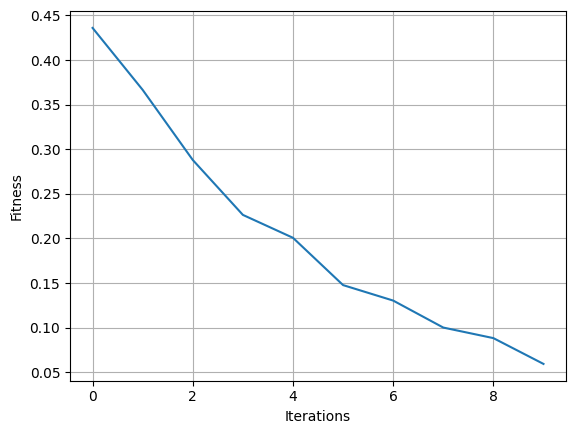

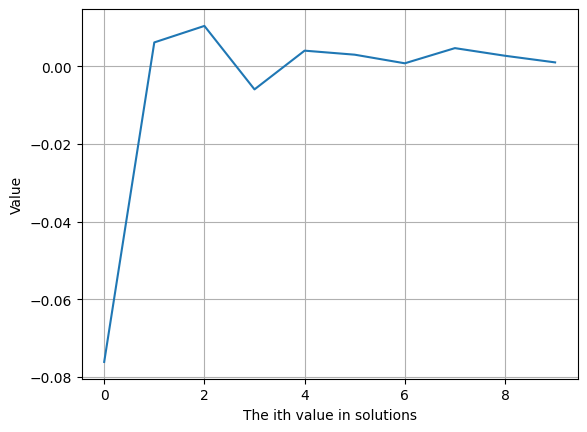

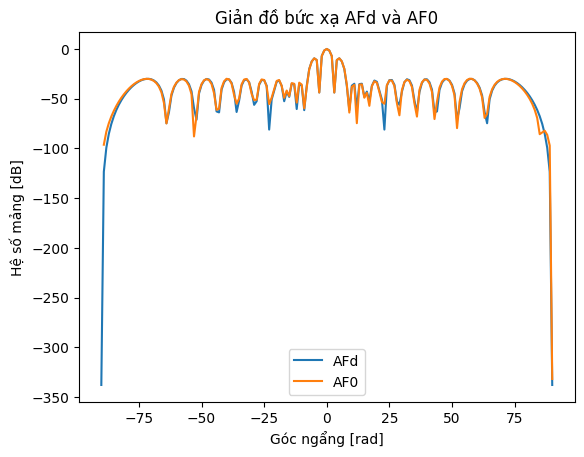

Thời gian chạy: 27.93400764465332 giây


In [ ]:
executionTime_MC = []
convergence_MC = []
bestIndividual_MC = []
for ind in range(MAX_MC):
  print('MAC:',ind)
  s = BAT(lb, ub, dim, Npop, Max_iteration)
  executionTime_MC.append(s.executionTime) # time execution
  convergence_MC.append(s.convergence)
  bestIndividual_MC.append(s.bestIndividual)
  pass

executionTime_aver = np.mean(executionTime_MC,0)
convergence_aver = np.mean(convergence_MC,0)
bestIndividual_aver = np.mean(bestIndividual_MC,0)

delta = np.concatenate((bestIndividual_aver, -np.flip(bestIndividual_aver)))
wo = wd * np.exp(1j*delta)
for i in theta:
  AF_0.append(np.power(np.abs(tinhAF_number(wo, i)), 2))
  AF_d.append(np.power(np.abs(tinhAF_number(wd, i)), 2))

P_db0 = 10 * np.log10(AF_0)
P_db0 = P_db0 - np.max(P_db0)


P_dbd = 10 * np.log10(AF_d)
P_dbd = P_dbd - np.max(P_dbd)
print("giá trị max của AF_d: " + str(np.max(AF_d)))
print("giá trị max của AF0: " + str(np.max(AF_0)))
end_time = time.time()

# Visualize
plt.figure(1)
plt.plot(np.arange(Max_iteration), convergence_aver)
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid()

plt.figure(2)
plt.plot(np.arange(dim), bestIndividual_aver)
plt.xlabel("The ith value in solutions")
plt.ylabel("Value")
plt.grid()

plt.figure(3)
plt.title("Giản đồ bức xạ AFd và AF0")
plt.xlabel("Góc ngẩng [rad]")
plt.ylabel("Hệ số mảng [dB]")
plt.plot(theta , P_dbd - np.max(P_dbd), label="AFd")
plt.plot(theta , P_db0 - np.max(P_db0), label="AF0")
plt.legend()
plt.show()


# Calculate time
execution_time = end_time - start_time

# Print results
print(f"Thời gian chạy: {execution_time} giây")
